### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'patient_sex'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 5e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... vascular_occlusion  \
0      yes            1         1      yes  ...                  0   
1      yes            1         2      yes  ...                  0   
2      yes            2         1      yes  ...                  0   
3      yes            2         2      yes  ...                  0   
4      yes            1         1      yes  ...                  0   

  hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                        0        0           0                   0   
1                        0        0           0                   0   
2                        0        0           0                   0   
3                        0        0           0                   0   
4                        0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  normality  
0              0                   1      0  Adequate   abnormal  
1              0                   1      0  Adequate   abnormal  
2              0                   0      0  Adequate     normal  
3              0                   0      0  Adequate     normal  
4              0                   0      0  Adequate     normal  

[5 rows x 35 columns]

In [4]:
# Convert into 3 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Male' if x == 1 else 'Female')

Train data shape: (11386, 35)
Test data shape: (4880, 35)


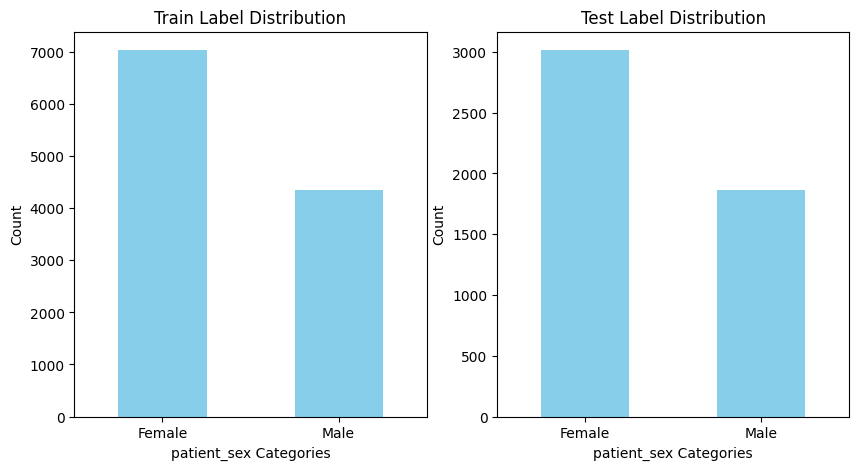

Getting validation set...
Train data shape: (10247, 35)
Test data shape: (1139, 35)


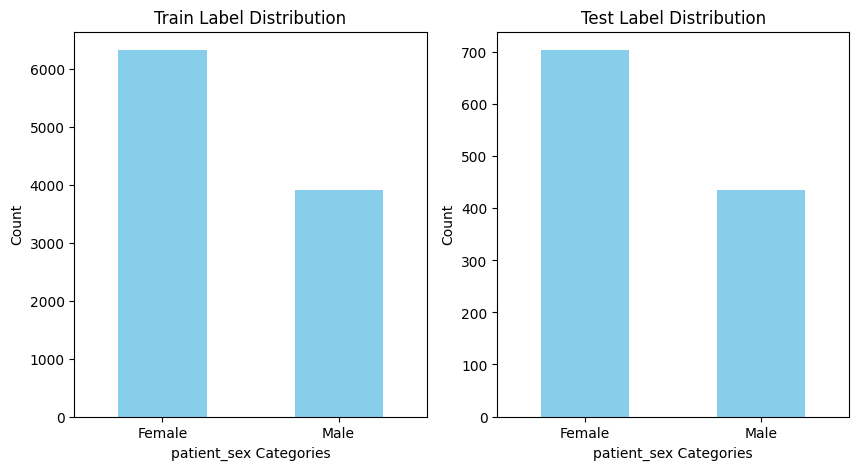

In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_train, df_val = split_data(df_train, LABEL, 0.10)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

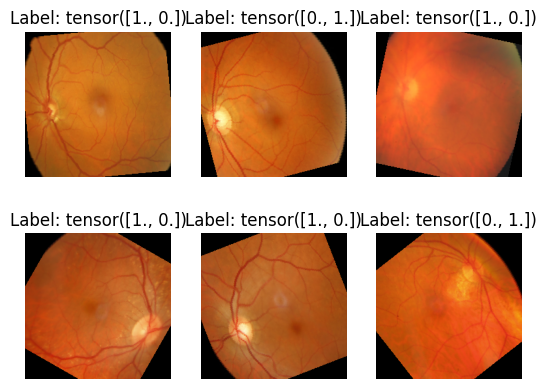

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone='convnextv2_binary_{LABEL}')

100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 1, Train Loss: 0.7144044519121673, Val Loss: 0.691132983399762, F1 Score: 0.5424343481036342


100%|██████████| 72/72 [00:20<00:00,  3.56it/s]


Epoch 2, Train Loss: 0.6835116809132319, Val Loss: 0.655801933672693, F1 Score: 0.5986436612491421


100%|██████████| 72/72 [00:20<00:00,  3.48it/s]


Epoch 3, Train Loss: 0.6506377378603597, Val Loss: 0.6267830340398682, F1 Score: 0.6282502266545784


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 4, Train Loss: 0.6163274311982153, Val Loss: 0.5895563252270222, F1 Score: 0.6872044312046174


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 5, Train Loss: 0.597321216383144, Val Loss: 0.6103723661767112, F1 Score: 0.6390224831648079


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 6, Train Loss: 0.5676035658803633, Val Loss: 0.578242606172959, F1 Score: 0.711381361765183


100%|██████████| 72/72 [00:20<00:00,  3.54it/s]


Epoch 7, Train Loss: 0.558278748983526, Val Loss: 0.5634449440985918, F1 Score: 0.7207842437482513


100%|██████████| 72/72 [00:20<00:00,  3.58it/s]


Epoch 8, Train Loss: 0.5465384889132519, Val Loss: 0.5819545990477005, F1 Score: 0.7102383000680497


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 9, Train Loss: 0.5381871865199248, Val Loss: 0.5413459233111806, F1 Score: 0.7007948722703308


100%|██████████| 72/72 [00:20<00:00,  3.45it/s]


Epoch 10, Train Loss: 0.5228909952173739, Val Loss: 0.6026057973504066, F1 Score: 0.618890540755606


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 11, Train Loss: 0.5029250946413151, Val Loss: 0.4908888635949956, F1 Score: 0.7386953992343932


100%|██████████| 72/72 [00:21<00:00,  3.42it/s]


Epoch 12, Train Loss: 0.49417616315360374, Val Loss: 0.7662160709086392, F1 Score: 0.5246335662352395


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 13, Train Loss: 0.4923237080274618, Val Loss: 0.4981182681189643, F1 Score: 0.7534205454040633


100%|██████████| 72/72 [00:20<00:00,  3.46it/s]


Epoch 14, Train Loss: 0.48625769334817637, Val Loss: 0.4903260295589765, F1 Score: 0.7492934940734463


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 15, Train Loss: 0.46269886407204985, Val Loss: 0.4815707533723778, F1 Score: 0.7566881542076626


100%|██████████| 72/72 [00:20<00:00,  3.46it/s]


Epoch 16, Train Loss: 0.4719496162233412, Val Loss: 0.5099429657889737, F1 Score: 0.7368795730557441


100%|██████████| 72/72 [00:20<00:00,  3.55it/s]


Epoch 17, Train Loss: 0.4552399361979757, Val Loss: 0.4728519672320949, F1 Score: 0.7642072534781668


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 18, Train Loss: 0.43638882129315093, Val Loss: 0.45773174862066907, F1 Score: 0.7538299197782778


100%|██████████| 72/72 [00:20<00:00,  3.55it/s]


Epoch 19, Train Loss: 0.4275901465678178, Val Loss: 0.4682807680219412, F1 Score: 0.7582072482443394


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 20, Train Loss: 0.41649493677381794, Val Loss: 0.46448985901143813, F1 Score: 0.767096502102317


100%|██████████| 72/72 [00:20<00:00,  3.53it/s]


Epoch 21, Train Loss: 0.407519229674674, Val Loss: 0.4864751733839512, F1 Score: 0.7804968312765623


100%|██████████| 72/72 [00:20<00:00,  3.45it/s]


Epoch 22, Train Loss: 0.3929327549921369, Val Loss: 0.4725487178398503, F1 Score: 0.7665143078755644


100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


Epoch 23, Train Loss: 0.38130073790989133, Val Loss: 0.47920665165616405, F1 Score: 0.7763983301089502


100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


Epoch 24, Train Loss: 0.38174314276197585, Val Loss: 0.5527194477617741, F1 Score: 0.7362521365171537


100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 25, Train Loss: 0.3645348881666262, Val Loss: 0.47935380869441563, F1 Score: 0.7832460837862742


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 26, Train Loss: 0.3486874699011422, Val Loss: 0.5060102765758833, F1 Score: 0.7590185875019908


100%|██████████| 72/72 [00:20<00:00,  3.59it/s]


Epoch 27, Train Loss: 0.34299600019748794, Val Loss: 0.5334322984433837, F1 Score: 0.7489323254392012


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 28, Train Loss: 0.32513985004095874, Val Loss: 0.5244609181665711, F1 Score: 0.7746588049090579


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 29, Train Loss: 0.32015880530877344, Val Loss: 0.5695083600779375, F1 Score: 0.7553672987553075


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 30, Train Loss: 0.30352569776536337, Val Loss: 0.5764886021821035, F1 Score: 0.75079594339439


100%|██████████| 72/72 [00:20<00:00,  3.58it/s]


Epoch 31, Train Loss: 0.3039502911211548, Val Loss: 0.5106389350775216, F1 Score: 0.7507021853420499


100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


Epoch 32, Train Loss: 0.2964926839002674, Val Loss: 0.5715608296708928, F1 Score: 0.7524486043268058
Early stopping triggered.


### Test

100%|██████████| 305/305 [01:24<00:00,  3.62it/s]


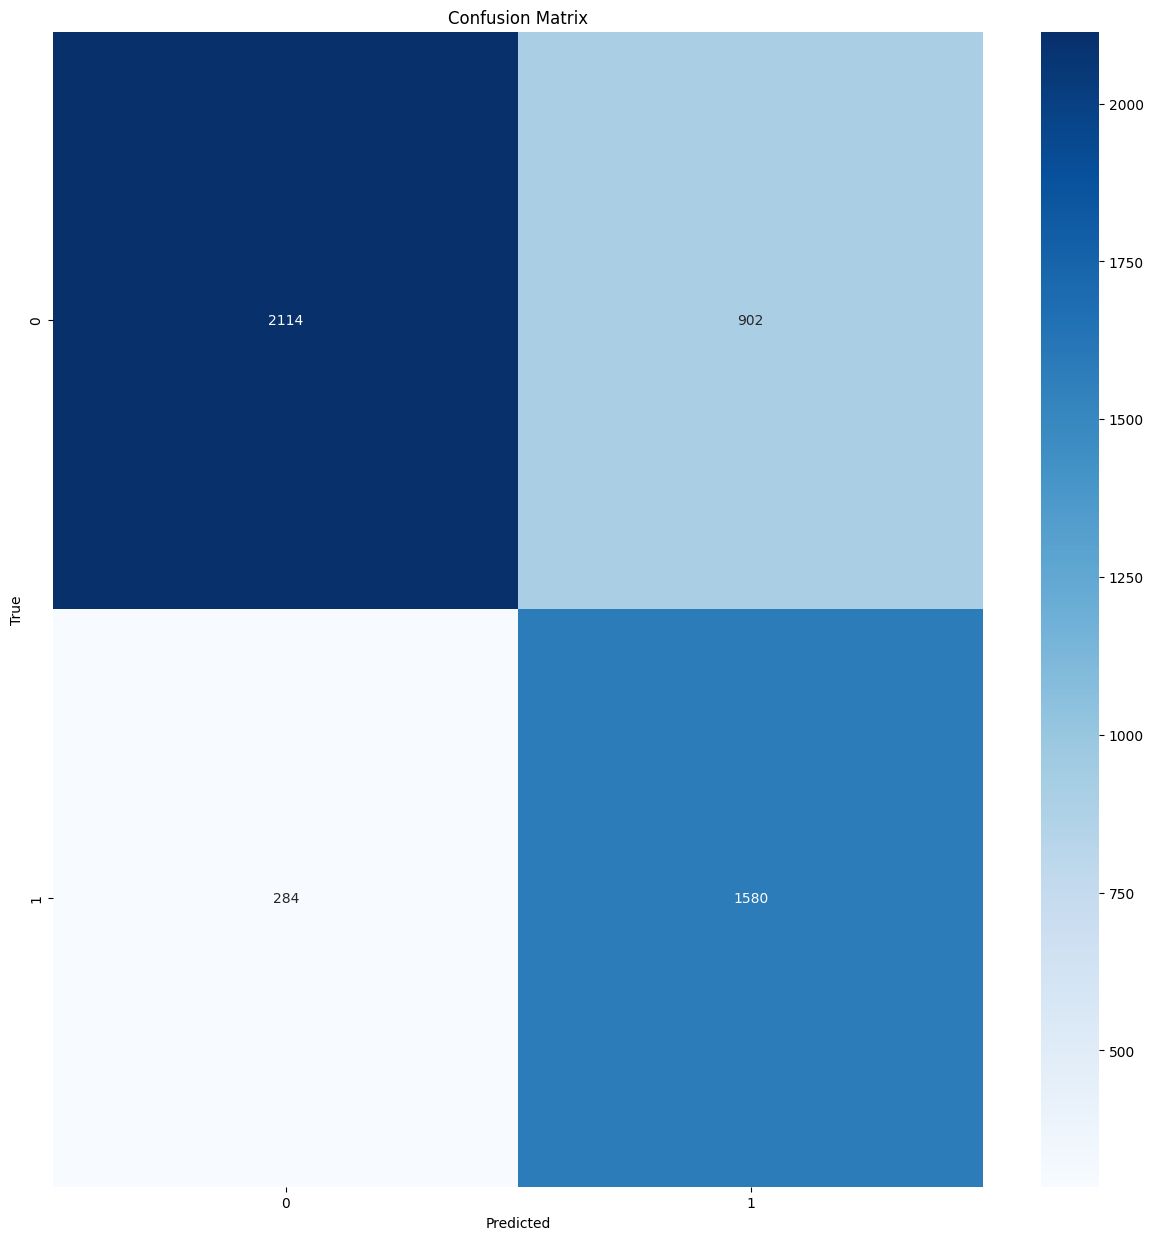

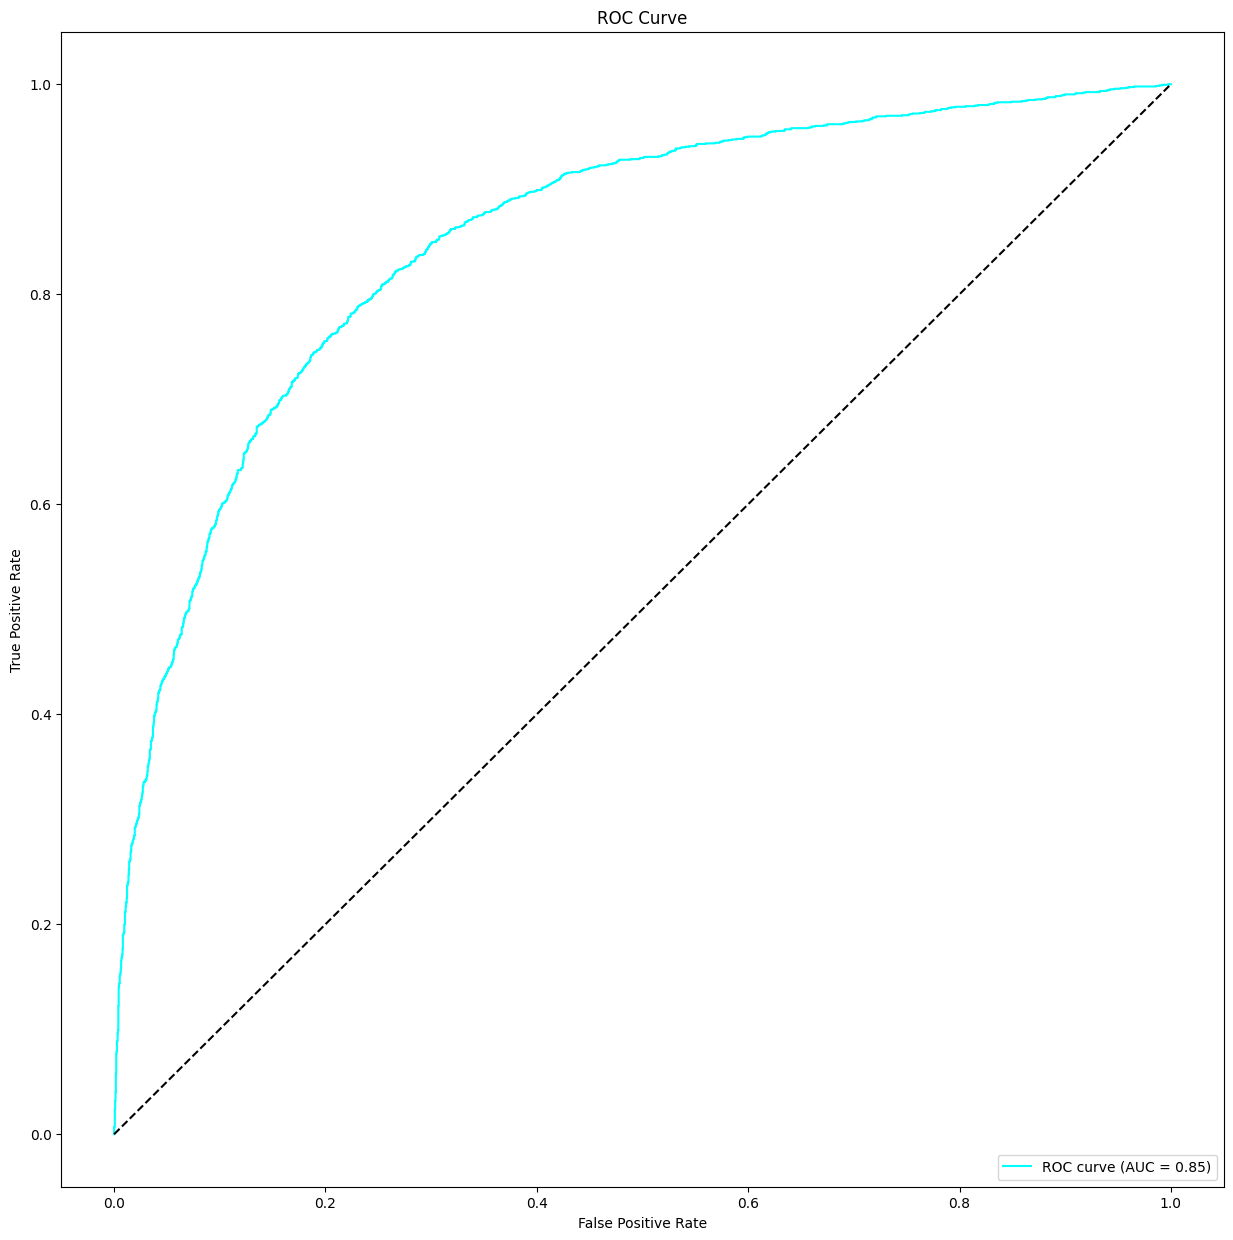

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      3016
           1       0.64      0.85      0.73      1864

    accuracy                           0.76      4880
   macro avg       0.76      0.77      0.75      4880
weighted avg       0.79      0.76      0.76      4880

##################################################  Saliency Maps  ##################################################

Class 0:


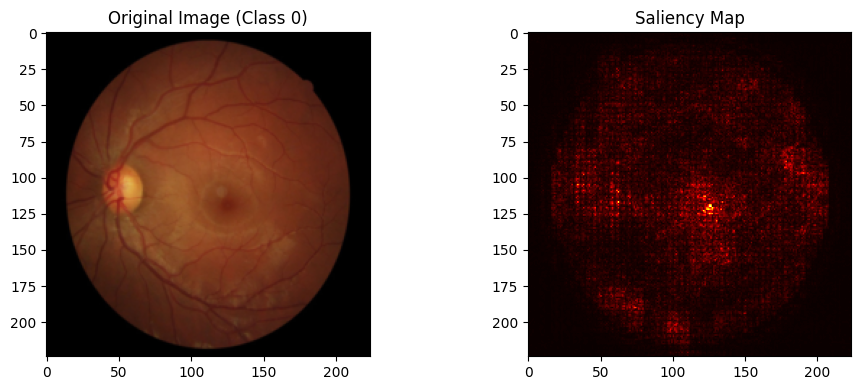

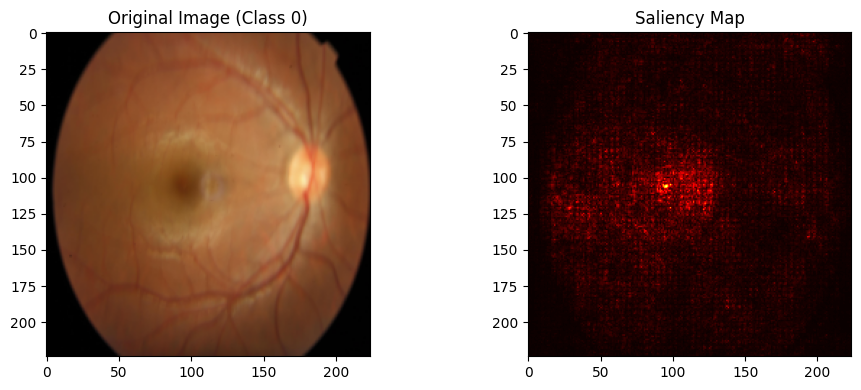

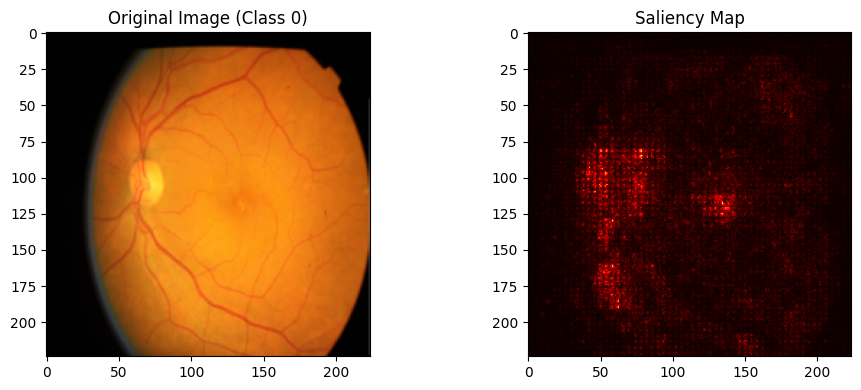

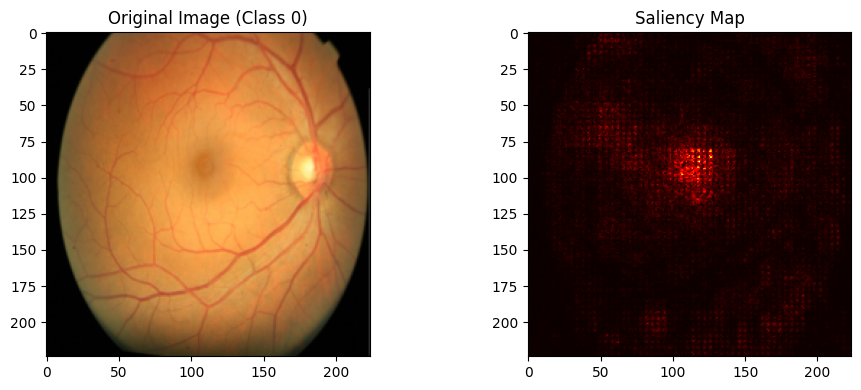

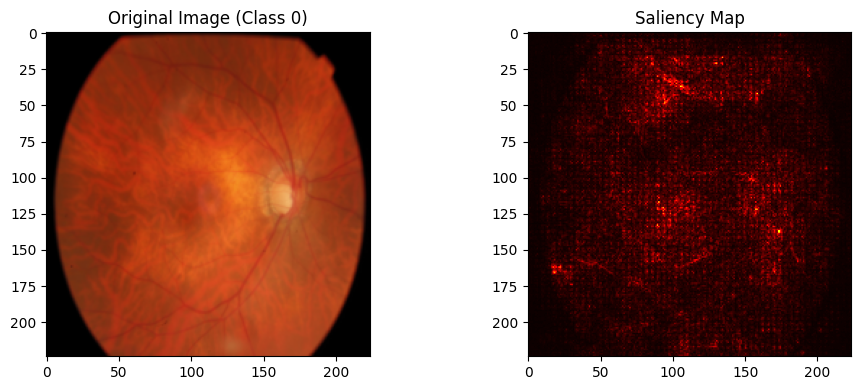

Class 1:


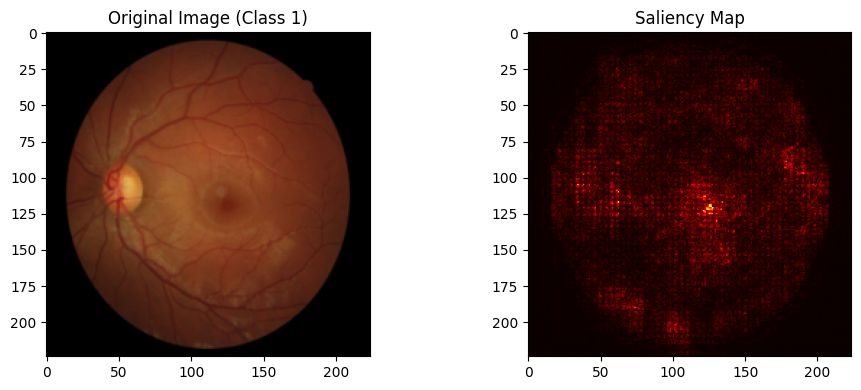

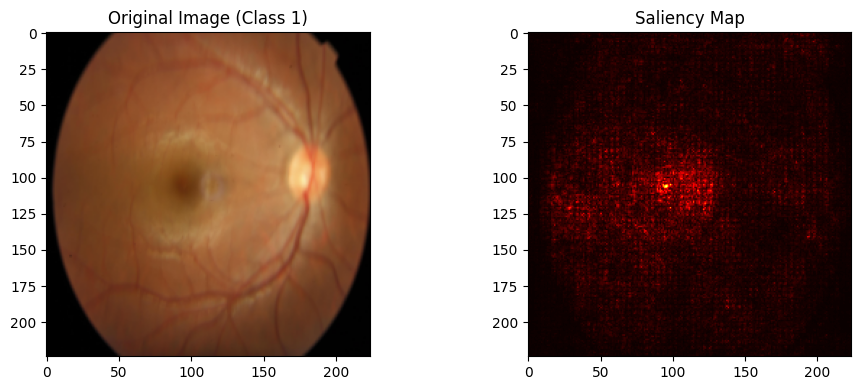

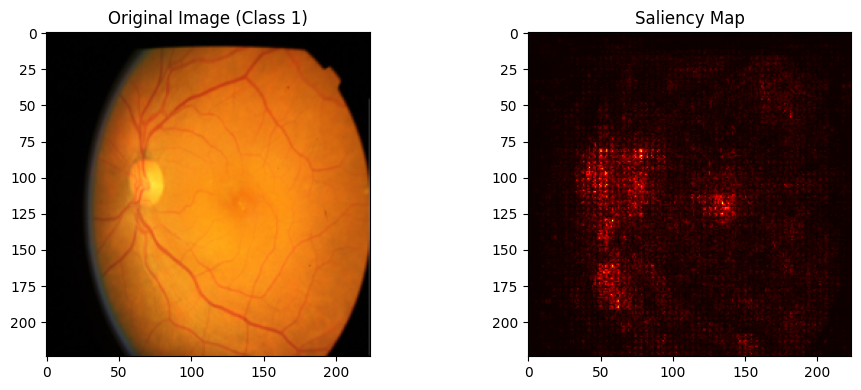

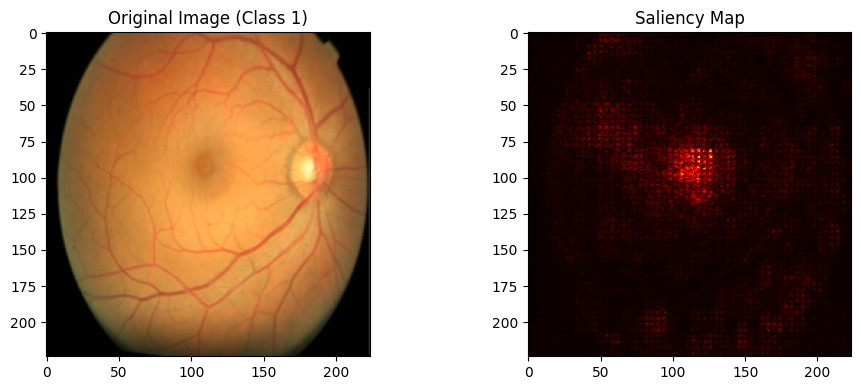

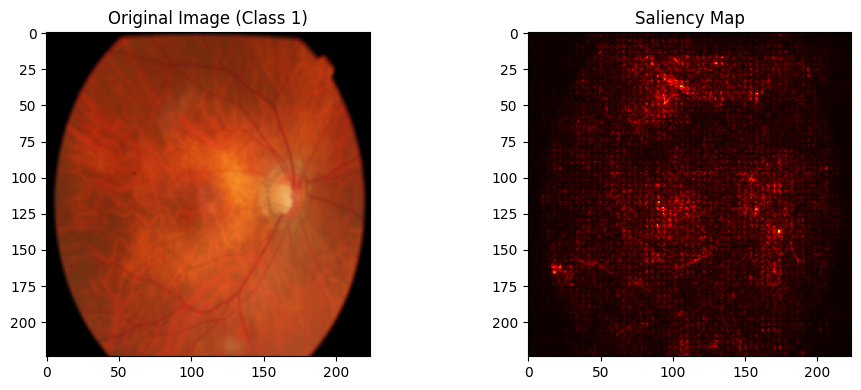

In [13]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 267/267 [01:15<00:00,  3.55it/s]


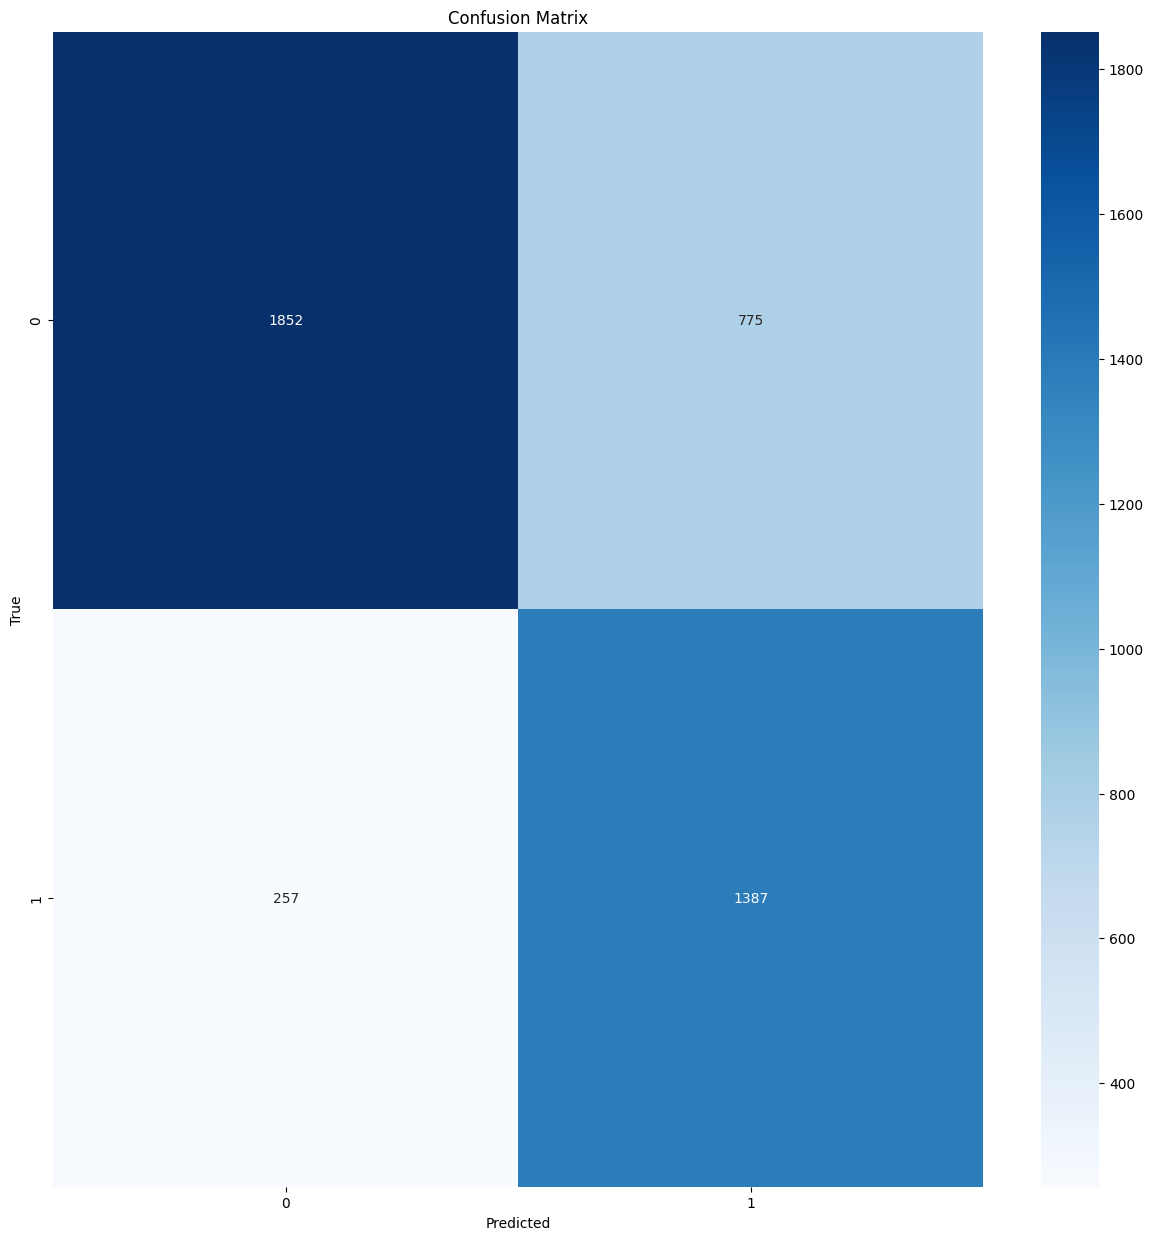

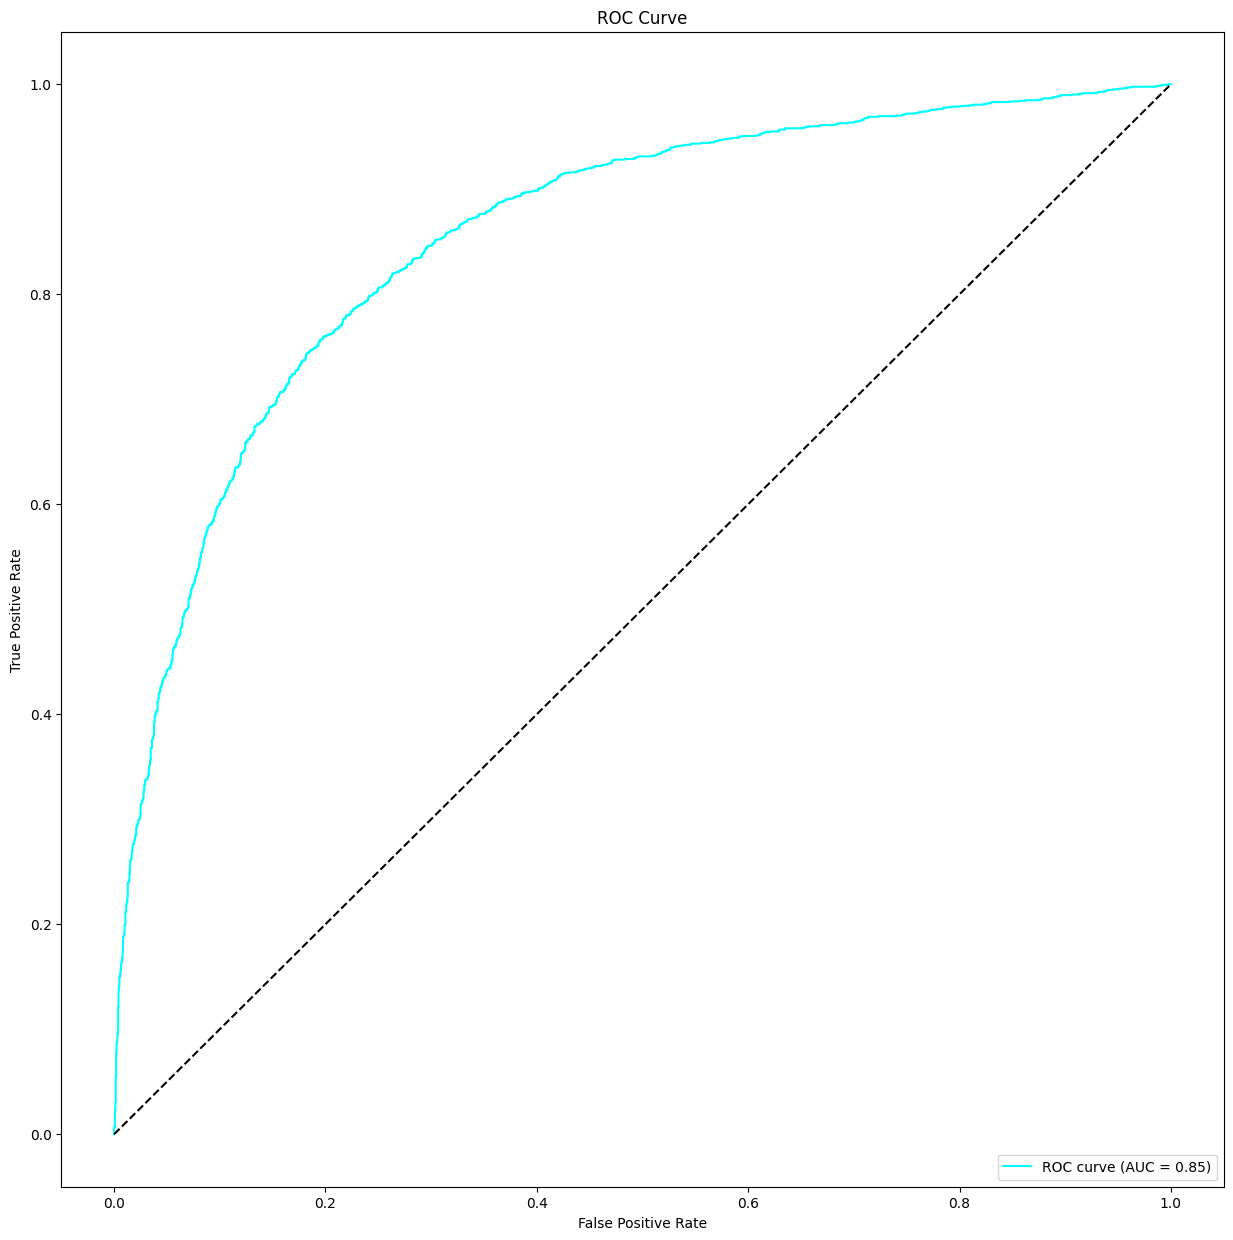

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      2627
           1       0.64      0.84      0.73      1644

    accuracy                           0.76      4271
   macro avg       0.76      0.77      0.76      4271
weighted avg       0.79      0.76      0.76      4271

##################################################  Saliency Maps  ##################################################

Class 0:


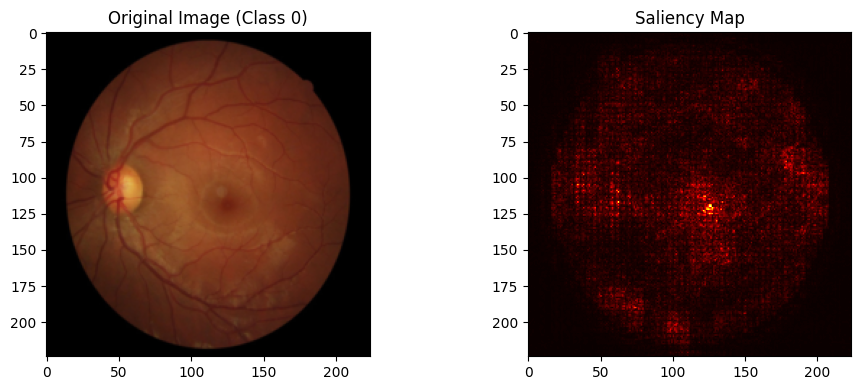

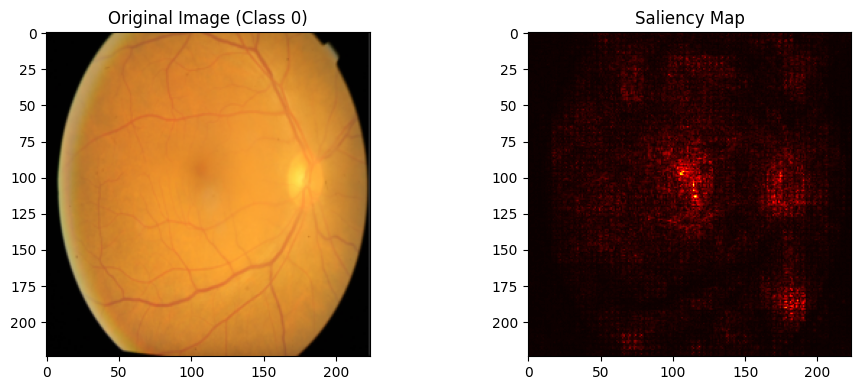

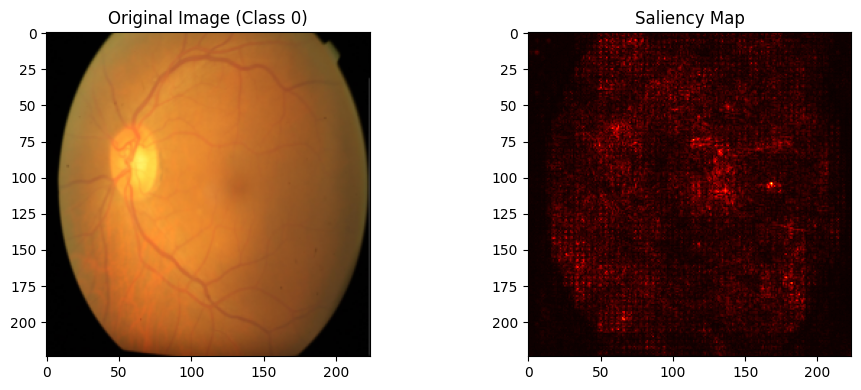

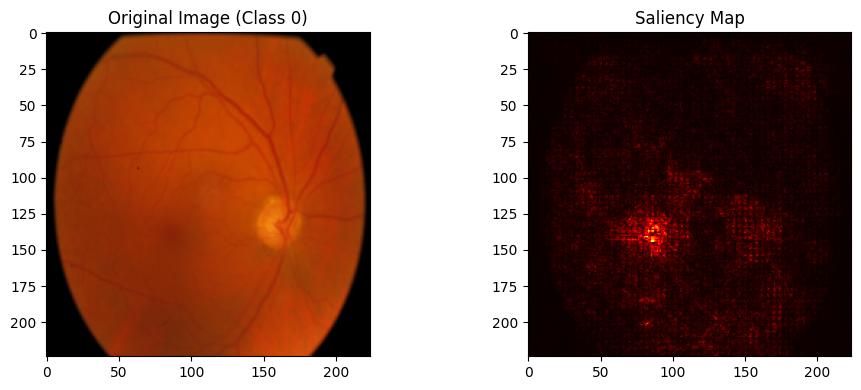

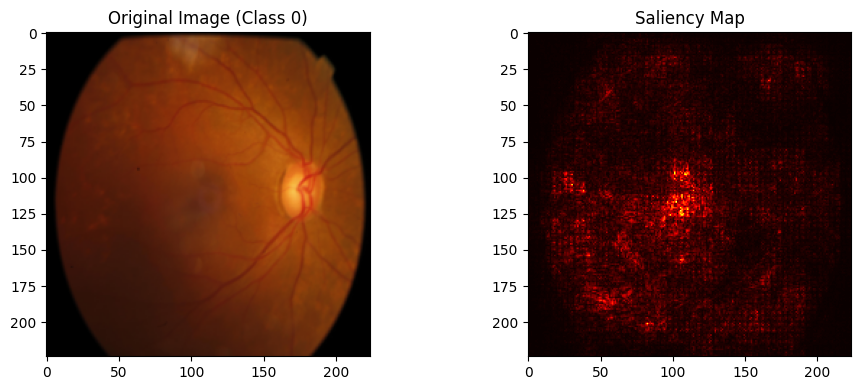

Class 1:


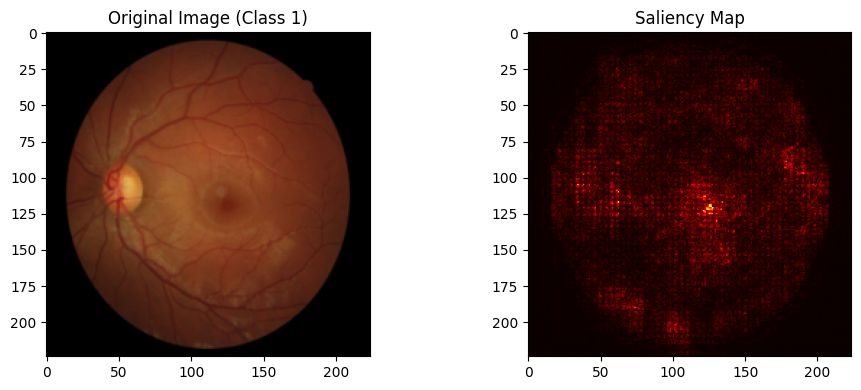

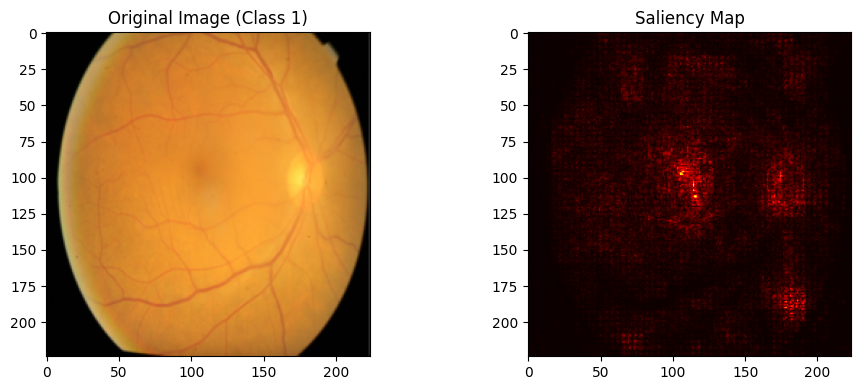

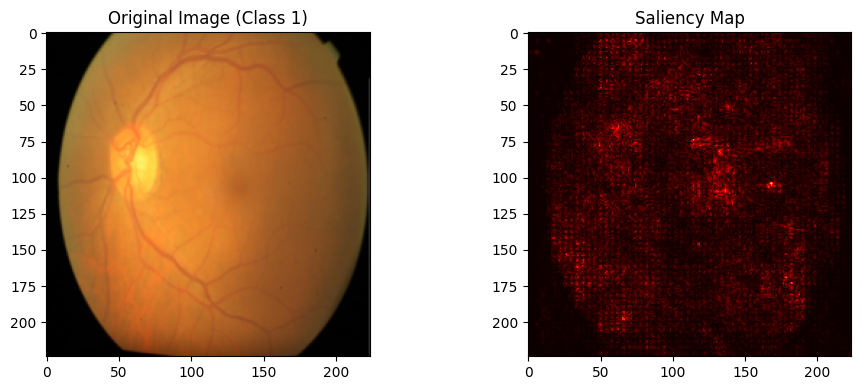

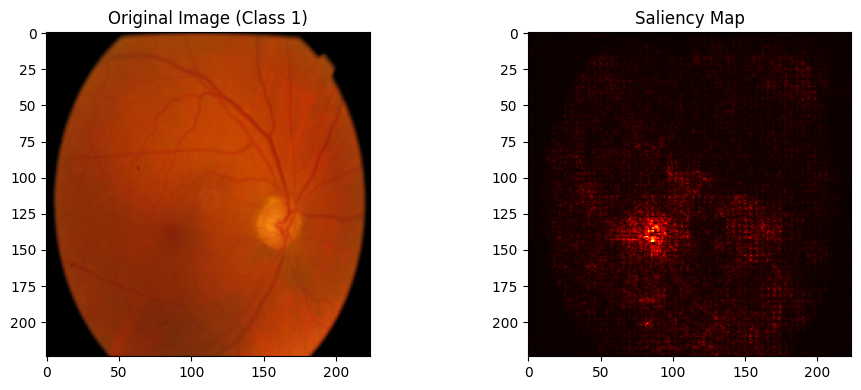

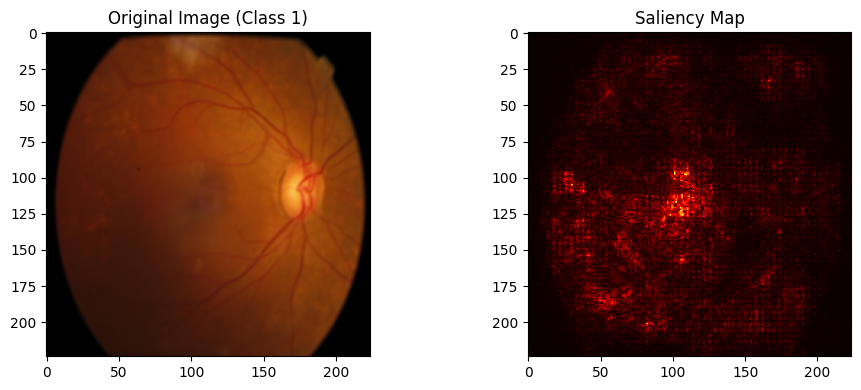

In [15]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 39/39 [00:11<00:00,  3.32it/s]


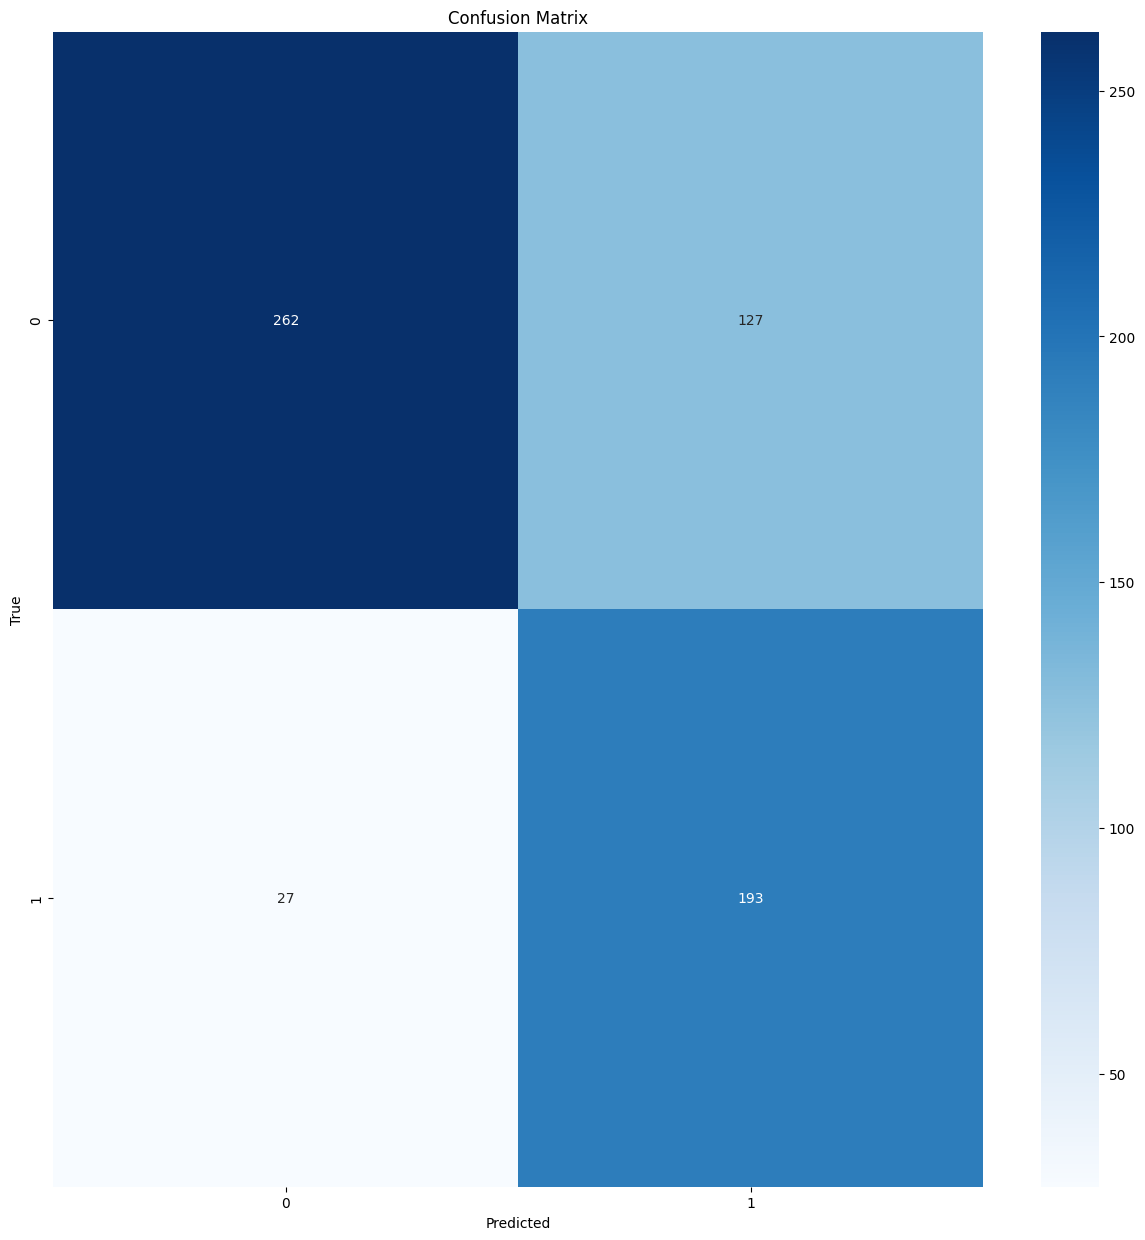

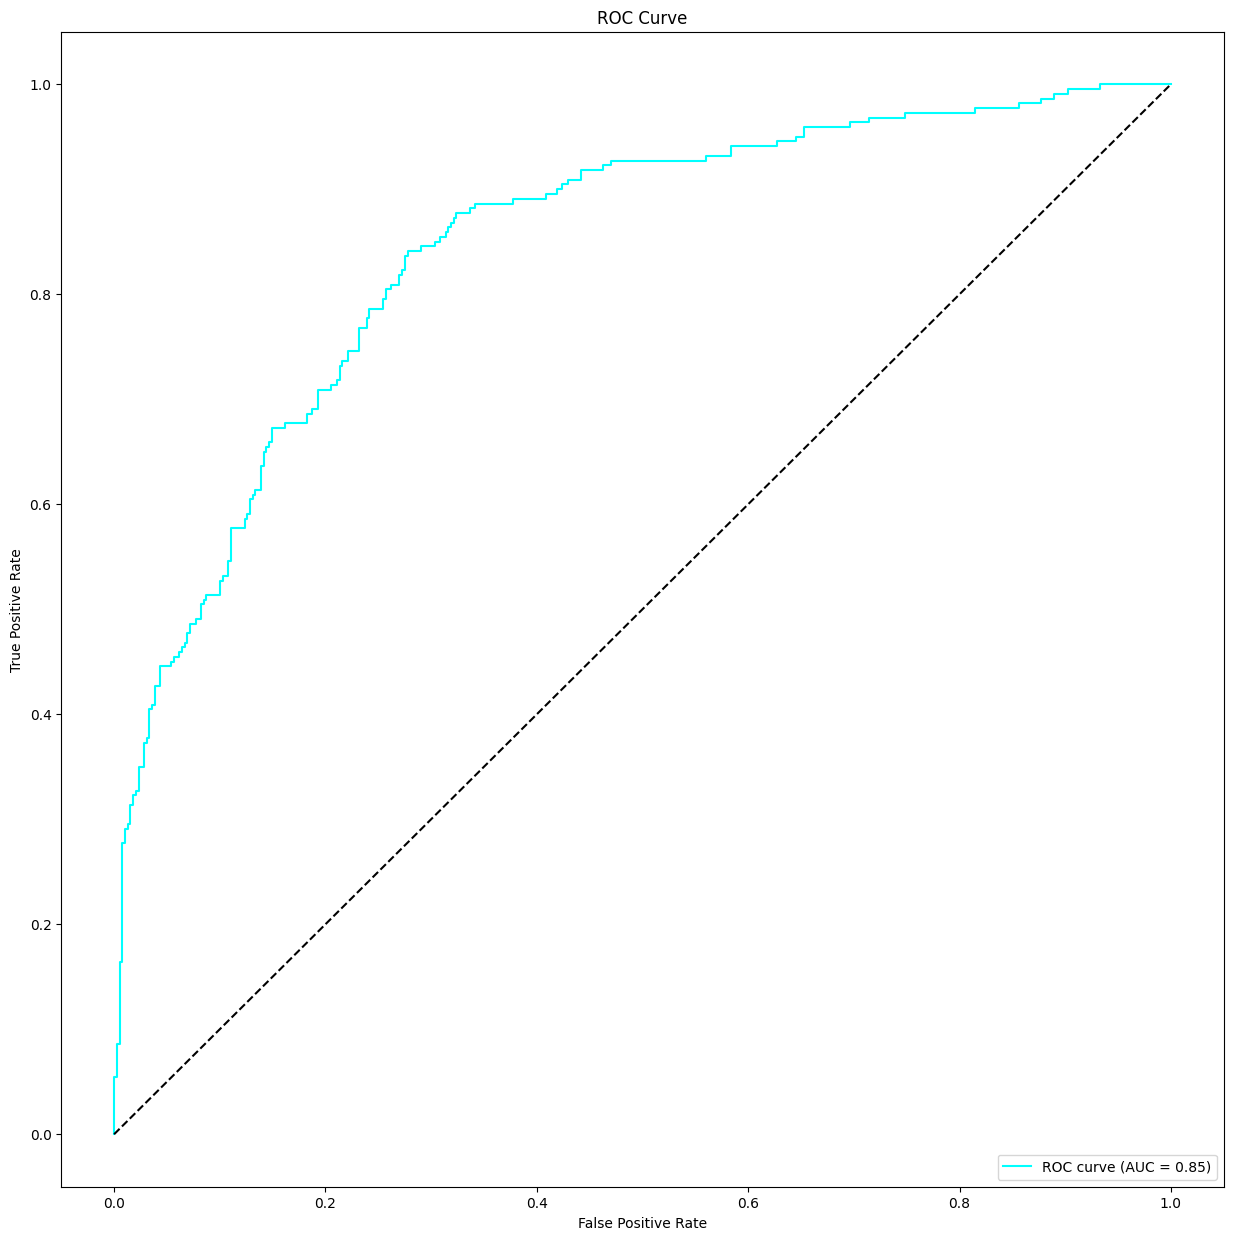

              precision    recall  f1-score   support

           0       0.91      0.67      0.77       389
           1       0.60      0.88      0.71       220

    accuracy                           0.75       609
   macro avg       0.75      0.78      0.74       609
weighted avg       0.80      0.75      0.75       609

##################################################  Saliency Maps  ##################################################

Class 0:


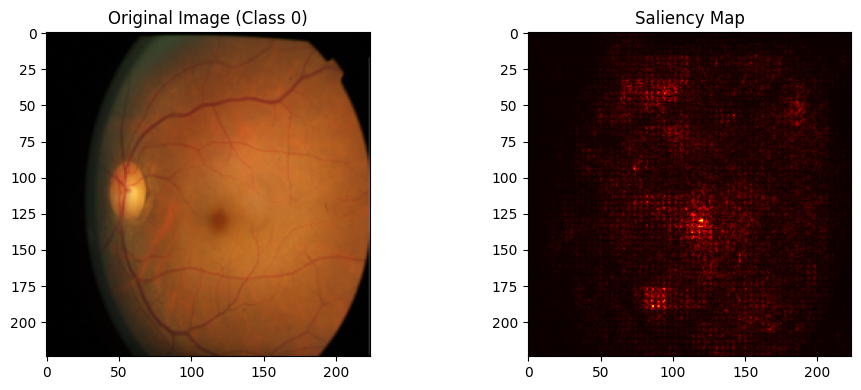

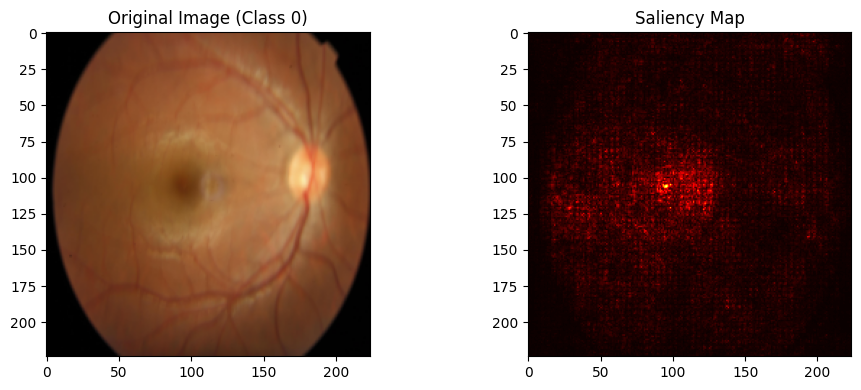

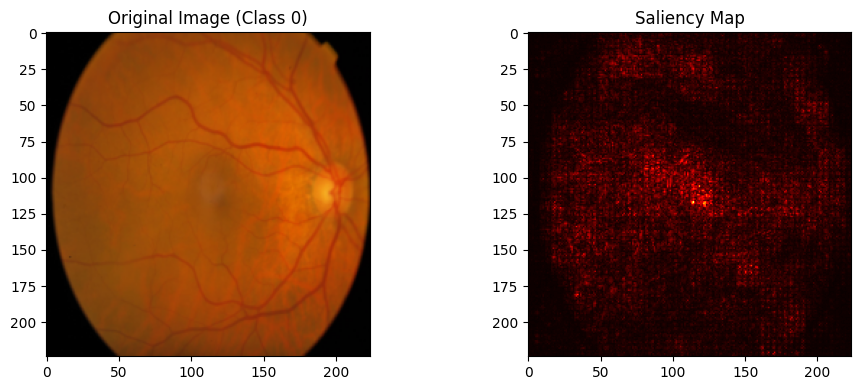

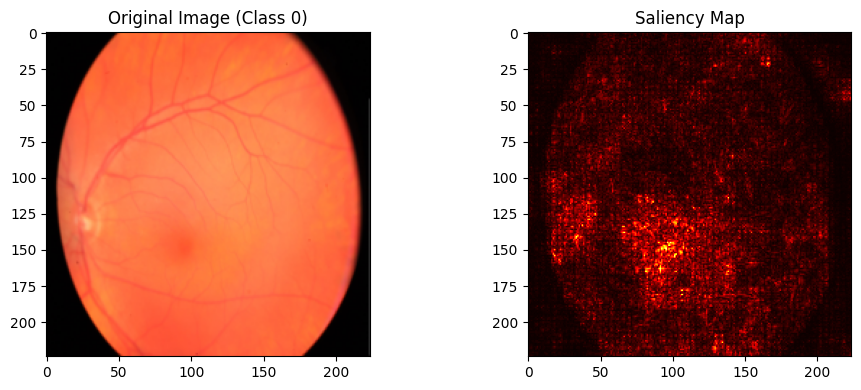

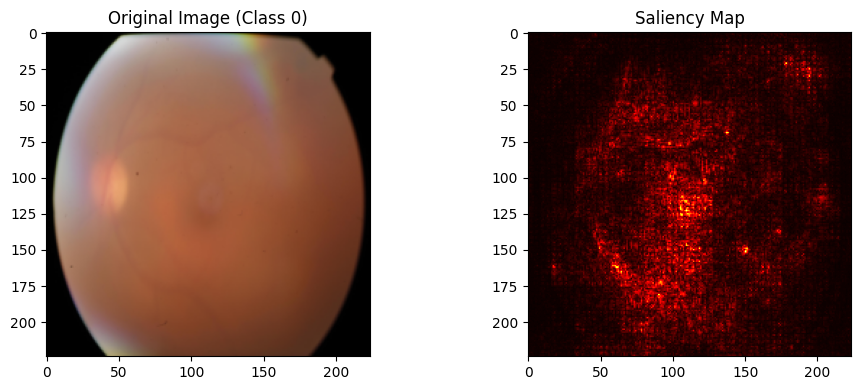

Class 1:


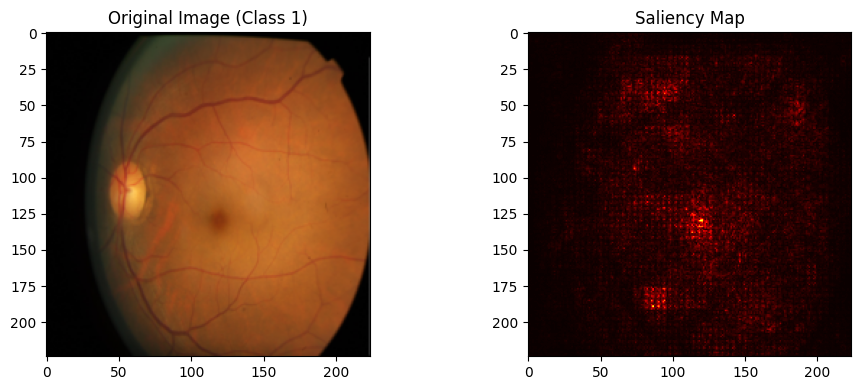

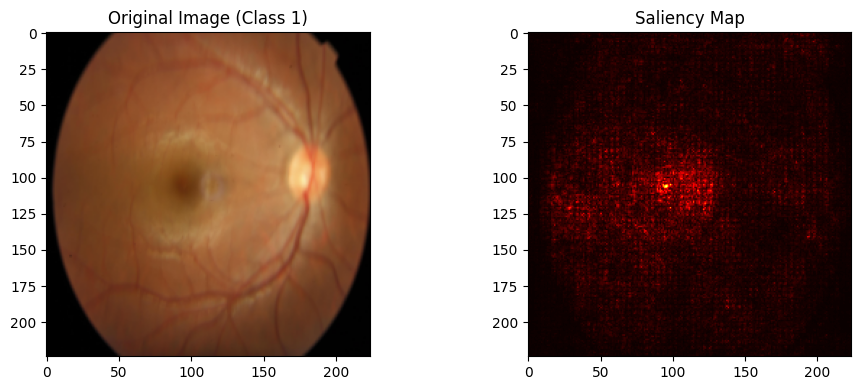

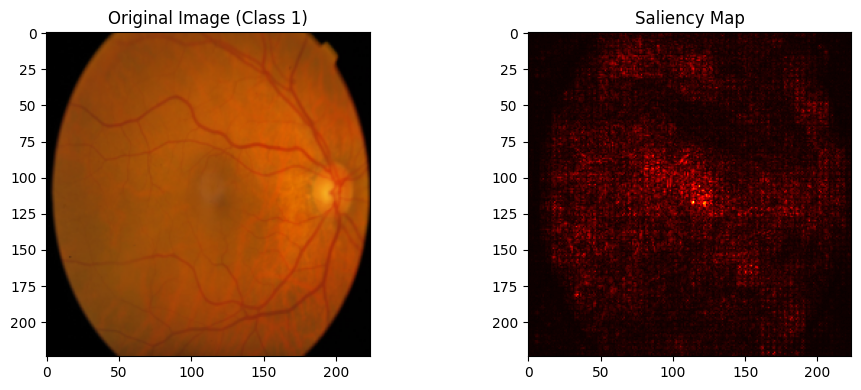

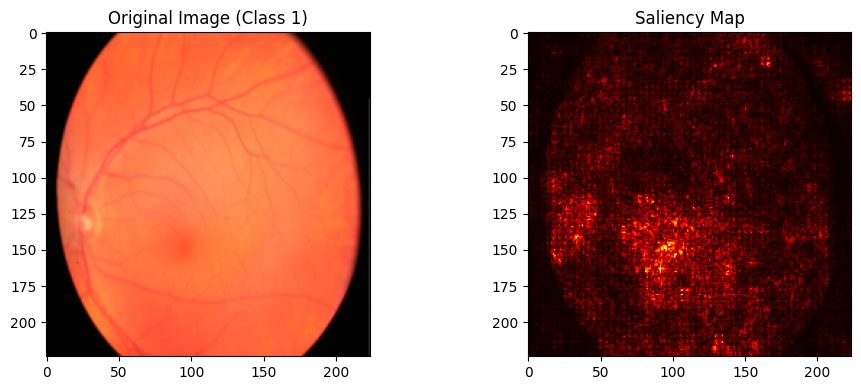

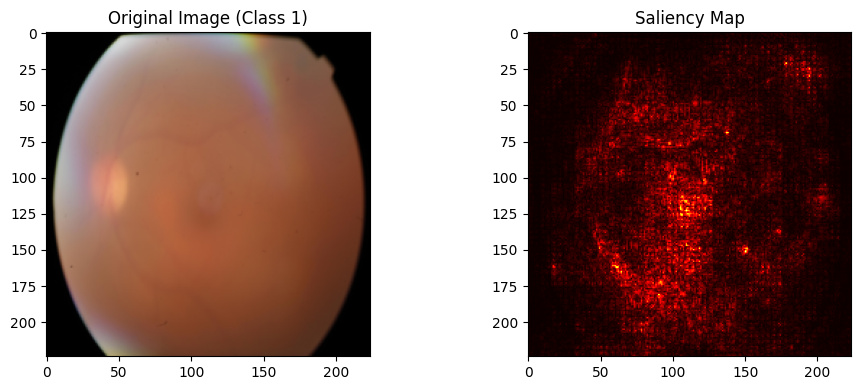

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)